In [1]:
import pickle as pk
from imdb_indexer import word2index
import numpy as np
import pandas as pd
import itertools
import os
from functions import make_ngram, uptoNgram
import tqdm
import matplotlib.pyplot as plt
from bow import BagOfWords, test_model


In [2]:
ngram_dct = pk.load(open("ngram_dct.pk", "rb"))
train_label = pk.load(open("train_label.pk", "rb"))
test_label = pk.load(open("test_label.pk", "rb"))
val_label = pk.load(open("val_label.pk", "rb"))


In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset

class IMDbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [4]:
train_features = ngram_dct['train_1']
val_features = ngram_dct['val_1']
test_features = ngram_dct['test_1']

In [5]:
max_vocab_size = 20000
PAD_IDX = 0
UNK_IDX = 1
all_train_features = list(itertools.chain.from_iterable(train_features))

builder = word2index(PAD_IDX, UNK_IDX)
#build vocab
token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
train_data_indices = builder.token2index_dataset(train_features)
val_data_indices = builder.token2index_dataset(val_features)
test_data_indices = builder.token2index_dataset(test_features)
MAX_SENTENCE_LENGTH = 200

# create pytorch dataloader
BATCH_SIZE = 64
train_dataset = IMDbDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

## sgd

In [8]:
#sgd -- no decay
lr_list = [0.01, 0.05, 0.1, 0.5]
val_curve_sgd_lr = []
val_acc_sgd_lr = []
for learning_rate in lr_list:
    learning_rate_decay = False
    num_epochs = 10
    emb_dim = 300
    model = BagOfWords(len(id2token), emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
    val_acc_list = []
    for epoch in tqdm.trange(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            val_acc = test_model(val_loader, model)
            optimizer.step()
        
        val_acc_list.append(val_acc)
        if learning_rate_decay == True:
            scheduler.step(val_acc)


    val_curve_sgd_lr.append(val_acc_list)
    val_acc_sgd_lr.append(test_model(val_loader, model))
    print('finish learning rate %s, val_acc: %s' %(learning_rate, test_model(val_loader, model)))

  0%|          | 0/10 [00:00<?, ?it/s]

finish learning rate 0.01, val_acc: 71.88


  0%|          | 0/10 [00:00<?, ?it/s]

finish learning rate 0.05, val_acc: 78.34


  0%|          | 0/10 [00:00<?, ?it/s]

finish learning rate 0.1, val_acc: 80.22


100%|██████████| 10/10 [42:51<00:00, 257.14s/it]


finish learning rate 0.5, val_acc: 84.22


In [37]:
#learning rate decay
learning_rate = 1
learning_rate_decay = True
num_epochs = 10
emb_dim = 300
model = BagOfWords(len(id2token), emb_dim)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 1)
val_acc_list = []
for epoch in tqdm.trange(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        val_acc = test_model(val_loader, model)
        optimizer.step()
    
    val_acc_list.append(val_acc)
    if learning_rate_decay == True:
        scheduler.step(val_acc)

val_curve_sgd_lr.append(val_acc_list)
val_acc_sgd_lr.append(test_model(val_loader, model))
print('finish learning rate decay from %s, val_acc: %s' %(learning_rate, test_model(val_loader, model)))




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [03:55<35:15, 235.01s/it]


 20%|██        | 2/10 [07:49<31:17, 234.65s/it]


 30%|███       | 3/10 [11:43<27:21, 234.44s/it]


 40%|████      | 4/10 [15:38<23:27, 234.53s/it]


 50%|█████     | 5/10 [19:32<19:32, 234.55s/it]


 60%|██████    | 6/10 [23:31<15:40, 235.18s/it]


 70%|███████   | 7/10 [27:26<11:45, 235.20s/it]


 80%|████████  | 8/10 [31:42<07:55, 237.84s/it]


 90%|█████████ | 9/10 [35:59<03:59, 239.93s/it]


100%|██████████| 10/10 [40:15<00:00, 241.55s/it]




finish learning rate decay from 1, val_acc: 85.38


In [39]:
val_curve_sgd_lr

[[67.62, 68.9, 69.26, 70.44, 71.18, 71.32, 71.68, 72.12, 72.24, 71.88],
 [70.98, 73.92, 73.82, 75.7, 75.38, 76.88, 77.02, 77.32, 77.24, 78.14],
 [72.3, 75.32, 75.9, 77.04, 77.48, 78.2, 78.9, 78.42, 79.66, 80.3],
 [75.56, 78.28, 81.4, 80.02, 82.82, 82.86, 80.84, 82.9, 84.74, 84.3],
 [74.96, 76.36, 82.16, 83.66, 82.52, 82.28, 85.38, 85.56, 85.28, 85.44]]

Text(0.5,1,'spacy tokenization, unigram, sgd optimization')

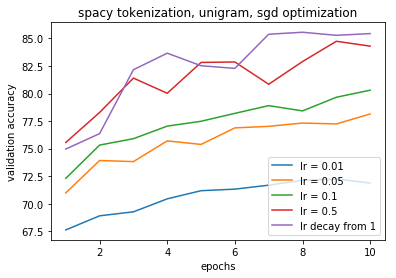

In [42]:
for i in range(len(val_curve_sgd_lr)-1):
    plt.plot(np.arange(1,num_epochs+1), val_curve_sgd_lr[i], label = 'lr = %s' %lr_list[i])
plt.plot(np.arange(1,num_epochs+1), val_curve_sgd_lr[-1], label = 'lr decay from 1')
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, unigram, sgd optimization')

In [43]:
C = pd.Index(["0.01", "0.05", "0.1", "0.5", "lr decay"], name="learning rate")
I = pd.Index(["sgd"], name="optimizer")
df = pd.DataFrame(data=np.random.rand(1,5), index=I, columns=C)

df.iloc[0] = val_acc_sgd_lr

df

learning rate,0.01,0.05,0.1,0.5,lr decay
optimizer,,,,,
sgd,71.88,78.34,80.22,84.22,85.38


## Adam

In [27]:
## adam - no decay
lr_list = [0.001, 0.005, 0.01]
val_curve_adam_lr = []
val_acc_adam_lr = []
for learning_rate in lr_list:
    learning_rate_decay = False
    num_epochs = 10
    emb_dim = 300
    model = BagOfWords(len(id2token), emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    val_acc_list = []
    for epoch in tqdm.trange(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            val_acc = test_model(val_loader, model)
            optimizer.step()

        val_acc_list.append(val_acc)
        if learning_rate_decay == True:
            scheduler.step(val_acc)
            

    val_curve_adam_lr.append(val_acc_list)
    val_acc_adam_lr.append(test_model(val_loader, model))
    print('finish learning rate %s, val_acc: %s' %(learning_rate, test_model(val_loader, model)))



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [05:04<45:39, 304.41s/it]

 20%|██        | 2/10 [10:08<40:32, 304.08s/it]

 30%|███       | 3/10 [15:12<35:29, 304.24s/it]

 40%|████      | 4/10 [20:18<30:27, 304.51s/it]

 50%|█████     | 5/10 [25:23<25:23, 304.73s/it]

 60%|██████    | 6/10 [30:28<20:19, 304.79s/it]

 70%|███████   | 7/10 [35:33<15:14, 304.81s/it]

 80%|████████  | 8/10 [40:37<10:09, 304.74s/it]

 90%|█████████ | 9/10 [45:41<05:04, 304.63s/it]

100%|██████████| 10/10 [50:46<00:00, 304.61s/it]



  0%|          | 0/10 [00:00<?, ?it/s]

finish learning rate 0.001, val_acc: 87.44




 10%|█         | 1/10 [04:53<44:02, 293.58s/it]

 20%|██        | 2/10 [09:17<37:09, 278.69s/it]

 30%|███       | 3/10 [13:40<31:54, 273.48s/it]

 40%|████      | 4/10 [18:03<27:05, 270.96s/it]

 50%|█████     | 5/10 [22:27<22:27, 269.42s/it]

 60%|██████    | 6/10 [26:51<17:54, 268.56s/it]

 70%|███████   | 7/10 [31:15<13:23, 267.96s/it]

 80%|████████  | 8/10 [35:39<08:54, 267.44s/it]

 90%|█████████ | 9/10 [40:03<04:27, 267.00s/it]

100%|██████████| 10/10 [44:26<00:00, 266.67s/it]



  0%|          | 0/10 [00:00<?, ?it/s]

finish learning rate 0.005, val_acc: 84.64




 10%|█         | 1/10 [04:19<38:56, 259.59s/it]

 20%|██        | 2/10 [08:07<32:31, 243.88s/it]

 30%|███       | 3/10 [11:56<27:52, 238.94s/it]

 40%|████      | 4/10 [15:44<23:37, 236.25s/it]

 50%|█████     | 5/10 [19:33<19:33, 234.80s/it]

 60%|██████    | 6/10 [23:21<15:34, 233.60s/it]

 70%|███████   | 7/10 [27:09<11:38, 232.72s/it]

 80%|████████  | 8/10 [30:56<07:44, 232.11s/it]

 90%|█████████ | 9/10 [34:44<03:51, 231.58s/it]

100%|██████████| 10/10 [38:32<00:00, 231.21s/it]



finish learning rate 0.01, val_acc: 84.58


Text(0.5,1,'spacy tokenization, unigram, adam optimization')

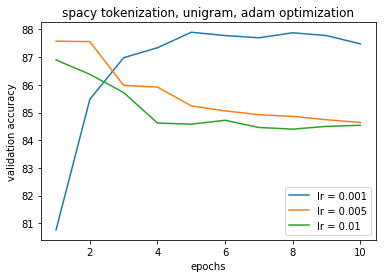

In [29]:
for i in range(len(val_curve_adam_lr)):
    plt.plot(np.arange(1,num_epochs+1), val_curve_adam_lr[i], label = 'lr = %s' %lr_list[i])
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('spacy tokenization, unigram, adam optimization')

In [44]:
C = pd.Index(["0.001", "0.005", "0.01"], name="learning rate")
I = pd.Index(["Adam"], name="optimizer")
df = pd.DataFrame(data=np.random.rand(1,3), index=I, columns=C)

df.iloc[0] = val_acc_adam_lr

df

learning rate,0.001,0.005,0.01
optimizer,,,
Adam,87.44,84.64,84.58
